In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Are peptide-generating genes forming clusters along the chromosomes?
Notebook by Assya Trofimov


In [2]:
### Here we load the peptide gene file
### Replace with your own file for the peptide genes you want to show.
genes = pd.read_csv('immunopep_breast2_lung6_ov23.csv', index_col=0)

In [ ]:
### Here you would subset your genes file according to peptide threshold
genes = genes['peptide_number

In [3]:
### Here we create the chromosome labels (1-23 and X)
chr_names = [str(i) for i in range(1,23)]
chr_names = chr_names+['X']
chr_names = [str(i) for i in chr_names]

### Here the chromosome file is loaded. It contains the size in bp of each chromosome
chromosome_sizes = pd.read_csv('./chr_file_n.txt',sep='\t',header=None)
chromosome_sizes.columns = ['chr','start','size']
chromosome_sizes['chr_ix'] = np.arange(chromosome_sizes.shape[0])

In [4]:
### Here we load the genome annotation
### This file comes from biomart and contains the gene ids and the chromosome and start/end positions
genome_annotation = pd.read_csv("./mart_export.txt",sep='\t')

In [5]:
pearson_maps = pd.read_csv('Pearsonetal2016_maps.csv')

In [9]:
from collections import Counter

### In this section we set the window size and the filename that will store the results.
window_size = 1000
result_filename = 'window_1kB.json'

import os
if result_filename in os.listdir('.'):
    with open(result_filename) as json_file:
        results_50000 = json.load(json_file)
else:


    ### creating an empty dictionary
    results_50000 = {}


    ### we will store results in various lists
    window_no = []
    window_yes = []
    window_random = []
    window_all = []
    window_pearson = []


    ### :Looping through chromosomes
    for chr_selection in list(chromosome_sizes['chr']):

        ### getting the chromosome size in base pairs
        selected_chr_size = list(chromosome_sizes[chromosome_sizes['chr']==chr_selection]['size'])[0]


        ### selecting only the genes on the chromosome
        selected_annotation = genome_annotation[genome_annotation['Chromosome/scaffold name']==chr_selection]
        ### refining our table to only keep gene id and start/stop
        selected_annotation = selected_annotation[['Gene stable ID', 'Gene start (bp)','Gene end (bp)']]

        ### Keeping only the ensembl gene name and number of peptides
        temp = genes[['ensembl_gene_id','peptide_number']]

        ### creating a boolean vector where for each gene we see if it generates a map
        generates_MAP = selected_annotation['Gene stable ID'].isin(temp['ensembl_gene_id'])
        ### replacing True and False by Yes and No
        generates_MAP = generates_MAP.replace(False, 'no')
        generates_MAP = generates_MAP.replace(True, 'yes')
        
        ### creating a boolean vector where for each gene we see if it generates a map in Pearson et al 2016
        generates_PearsonMAP = selected_annotation['Gene stable ID'].isin(pearson_maps['Gene ID'])
        ### replacing True and False by Yes and No
        generates_PearsonMAP = generates_PearsonMAP.replace(False, 'no')
        generates_PearsonMAP = generates_PearsonMAP.replace(True, 'yes')
        
        

        ### generating a permutation of this vector for the random selection of genes
        generates_MAP_rand = np.random.permutation(generates_MAP)

        ### adding the vectors to the table
        selected_annotation['generates_MAP'] = generates_MAP
        selected_annotation['generates_random'] = generates_MAP_rand
        selected_annotation['generates_Pearson'] = generates_PearsonMAP
        selected_annotation = selected_annotation.drop_duplicates()

        ### We are ready to start!
        print (f'Doing chromosome {chr_selection}')

        ### Looping through the windows along the chromosome
        for i in range(0,selected_chr_size,window_size):
            if i%10000000==0:
                ### sanity check print 
                print (f'{i/(10.**8)}/{selected_chr_size/(10.**8)}')

            ### create a boolean vector for genes that start within the window but end outside
            gstartinwindow = np.logical_and(selected_annotation['Gene start (bp)']>i,selected_annotation['Gene start (bp)']<i+window_size)
            ### create a boolean vector for genes that start  outside the window but end inside
            gstopinwindow = np.logical_and(selected_annotation['Gene end (bp)']>i,selected_annotation['Gene end (bp)']<i+window_size)
            ### create a boolean vector for genes that start and end inside the window
            gmidwindow = np.logical_and(selected_annotation['Gene start (bp)']<i,selected_annotation['Gene end (bp)']>i+window_size)

            ### assembling the boolean vectors to one single selection
            start_stop_select = np.logical_or(gstartinwindow, gstopinwindow)
            start_stop_select = np.logical_or(gmidwindow, start_stop_select)

            ### Treating the cases for the specific window:
            ### if the window has at least one gene
            if selected_annotation[start_stop_select].shape[0]>0:
                temp = selected_annotation[start_stop_select]
                ### add the number of genes to the all list
                window_all.append(temp.shape[0])
                ### add to the no list the number of No
                window_no.append(Counter(temp['generates_MAP'])['no'])
                ### add to the yes list the number of yes
                window_yes.append(Counter(temp['generates_MAP'])['yes'])
                ### count the number of yes in the randomized column
                window_random.append(Counter(temp['generates_random'])['yes'])
                ### count the number of yes in the pearson column
                window_pearson.append(Counter(temp['generates_Pearson'])['yes'])

            else:
                ### if no genes in the window, all list get update of 0
                window_no.append(0)
                window_yes.append(0)
                window_all.append(0)
                window_random.append(0)

    ### Storing the results into the dictionary
    results_50000['all'] = window_all
    results_50000['yes'] = window_yes
    results_50000['no']= window_no
    results_50000['random'] = window_random

    ### dumping the dictionary
    import json
    with open(result_filename, 'w') as fp:
        json.dump(results_50000, fp)

Doing chromosome 1
0.0/2.48956422
0.1/2.48956422
0.2/2.48956422
0.3/2.48956422
0.4/2.48956422
0.5/2.48956422
0.6/2.48956422
0.7/2.48956422
0.8/2.48956422
0.9/2.48956422
1.0/2.48956422
1.1/2.48956422
1.2/2.48956422
1.3/2.48956422
1.4/2.48956422
1.5/2.48956422
1.6/2.48956422
1.7/2.48956422
1.8/2.48956422
1.9/2.48956422
2.0/2.48956422
2.1/2.48956422
2.2/2.48956422
2.3/2.48956422
2.4/2.48956422
Doing chromosome 2
0.0/2.42193529
0.1/2.42193529
0.2/2.42193529
0.3/2.42193529
0.4/2.42193529
0.5/2.42193529
0.6/2.42193529
0.7/2.42193529
0.8/2.42193529
0.9/2.42193529
1.0/2.42193529
1.1/2.42193529
1.2/2.42193529
1.3/2.42193529
1.4/2.42193529
1.5/2.42193529
1.6/2.42193529
1.7/2.42193529
1.8/2.42193529
1.9/2.42193529
2.0/2.42193529
2.1/2.42193529
2.2/2.42193529
2.3/2.42193529
2.4/2.42193529
Doing chromosome 3
0.0/1.98295559
0.1/1.98295559
0.2/1.98295559
0.3/1.98295559
0.4/1.98295559
0.5/1.98295559
0.6/1.98295559
0.7/1.98295559
0.8/1.98295559
0.9/1.98295559
1.0/1.98295559
1.1/1.98295559
1.2/1.9829555

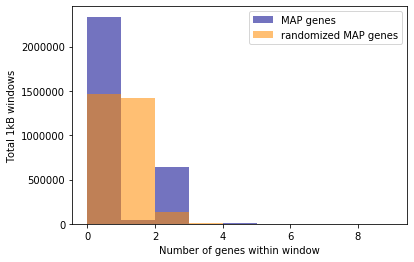

In [10]:
alpha = 0.55
plt.hist(window_yes,alpha=alpha, label='MAP genes',color='darkblue',bins=[i for i in range(10)])

plt.hist(window_random,alpha=alpha, label='randomized MAP genes',color='darkorange',bins=[i for i in range(10)])
plt.ylabel(f'Total {int(window_size/1000)}kB windows')
plt.xlabel('Number of genes within window')
plt.legend()
plt.savefig(f'MAPvsRANDOM_{window_size}kb.png')


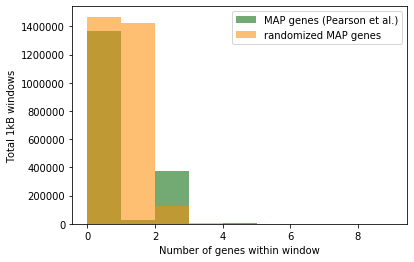

In [11]:
alpha = 0.55
#plt.hist(window_yes,alpha=alpha, label='MAP genes',color='darkblue',bins=[i for i in range(10)])
plt.hist(window_pearson,alpha=alpha, label='MAP genes (Pearson et al.)',color='darkgreen',bins=[i for i in range(10)])
plt.hist(window_random,alpha=alpha, label='randomized MAP genes',color='darkorange',bins=[i for i in range(10)])
plt.ylabel(f'Total {int(window_size/1000)}kB windows')
plt.xlabel('Number of genes within window')
plt.legend()
plt.savefig(f'PEARSONvsRANDOM_{window_size}kb.png')
